# Dynamic World Land Cover Exploration\n
\n
This notebook explores the Google Dynamic World land cover classification dataset for the Black Hills region, analyzing the distribution of different land cover types.

In [1]:
import os
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns

# Set plot style
plt.style.use('default')
sns.set_palette("Set3")

## Dynamic World Land Cover Classes\n\n
The Dynamic World dataset provides the following land cover classes:\n
- **0**: Water\n
- **1**: Trees\n
- **2**: Grass\n
- **3**: Flooded vegetation\n
- **4**: Crops\n
- **5**: Shrub and scrub\n
- **6**: Built area\n
- **7**: Bare ground\n
- **8**: Snow and ice

In [ ]:
# Define Dynamic World land cover classes
dw_classes = {
    0: 'Water',
    1: 'Trees',
    2: 'Grass',
    3: 'Flooded vegetation',
    4: 'Crops',
    5: 'Shrub and scrub',
    6: 'Built area',
    7: 'Bare ground',
    8: 'Snow and ice'
}

# Define colors for each class (official Google Earth Engine Dynamic World palette)
# From: https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1
dw_colors = {
    0: '#419BDF',  # Water
    1: '#397D49',  # Trees  
    2: '#88B053',  # Grass
    3: '#7A87C6',  # Flooded vegetation
    4: '#E49635',  # Crops
    5: '#DFC35A',  # Shrub and scrub
    6: '#C4281B',  # Built area
    7: '#A59B8F',  # Bare ground
    8: '#B39FE1'   # Snow and ice
}

print("Dynamic World Land Cover Classes:")
for class_id, class_name in dw_classes.items():
    print(f"{class_id}: {class_name}")

## Load Dynamic World Data

In [ ]:
# Path to Dynamic World data
dw_file = "../data/DW_BlackHills_mode.tif"

# Check if file exists
if not os.path.exists(dw_file):
    raise FileNotFoundError(f"Dynamic World file not found: {dw_file}")

# Load the data
try:
    dw_data = rxr.open_rasterio(dw_file, masked=True).squeeze()
    print(f"Loaded Dynamic World data: shape {dw_data.shape}")
    print(f"CRS: {dw_data.rio.crs}")
    print(f"Spatial extent: {dw_data.rio.bounds()}")
    print(f"Resolution: {dw_data.rio.resolution()}")
    
    # Let's calculate the actual geographic extent
    bounds = dw_data.rio.bounds()
    lat_extent = bounds[3] - bounds[1]  # max_lat - min_lat
    lon_extent = bounds[2] - bounds[0]  # max_lon - min_lon
    
    print(f"\nGeographic extent:")
    print(f"Latitude span: {lat_extent:.3f} degrees")
    print(f"Longitude span: {lon_extent:.3f} degrees")
    
    # Calculate approximate area using simple lat/lon to km conversion
    # At ~44°N latitude (center of Black Hills)
    center_lat = (bounds[1] + bounds[3]) / 2
    km_per_deg_lat = 111.32  # roughly constant
    km_per_deg_lon = 111.32 * np.cos(np.radians(center_lat))
    
    approx_area_km2 = lat_extent * km_per_deg_lat * lon_extent * km_per_deg_lon
    print(f"Approximate total area: {approx_area_km2:.1f} km²")
    
except Exception as e:
    raise RuntimeError(f"Error loading Dynamic World data: {e}")

# Check data range and unique values
unique_values = np.unique(dw_data.values[~np.isnan(dw_data.values)])
print(f"\nData characteristics:")
print(f"Unique land cover classes present: {unique_values}")
print(f"Data range: {dw_data.min().values} to {dw_data.max().values}")
print(f"Total pixels: {dw_data.size}")
print(f"Valid (non-NaN) pixels: {(~np.isnan(dw_data.values)).sum()}")

In [4]:
# Calculate area statistics for each land cover class
# Data is in geographic coordinates (degrees) - need proper area calculation
lat_res_deg = abs(dw_data.rio.resolution()[1])  # degrees
lon_res_deg = abs(dw_data.rio.resolution()[0])  # degrees

# Get center latitude for area calculation (extract the actual numeric value)
center_lat = float((dw_data.y.min() + dw_data.y.max()) / 2)
lat_rad = np.radians(center_lat)

# Convert to meters at center latitude
deg_to_m_lat = 111320  # meters per degree latitude
deg_to_m_lon = 111320 * np.cos(lat_rad)  # meters per degree longitude at this latitude

pixel_area_m2 = lat_res_deg * deg_to_m_lat * lon_res_deg * deg_to_m_lon
total_pixels = (~np.isnan(dw_data.values)).sum()
total_area_km2 = total_pixels * pixel_area_m2 / 1000000

# Calculate statistics for each class
class_stats = []
for class_id in unique_values:
    if not np.isnan(class_id):
        class_id = int(class_id)
        
        # Count pixels
        pixels = (dw_data.values == class_id).sum()
        
        # Calculate areas (ensure we get numeric values, not DataArrays)
        area_m2 = float(pixels * pixel_area_m2)
        area_km2 = area_m2 / 1000000
        area_ha = area_m2 / 10000
        
        # Calculate percentage
        percentage = (pixels / total_pixels) * 100
        
        class_stats.append({
            'Class_ID': class_id,
            'Class_Name': dw_classes.get(class_id, f'Unknown ({class_id})'),
            'Pixels': int(pixels),
            'Area_km2': area_km2,
            'Area_ha': area_ha,
            'Percentage': percentage,
            'Color': dw_colors.get(class_id, '#888888')
        })

# Create DataFrame and sort by area
stats_df = pd.DataFrame(class_stats)
stats_df = stats_df.sort_values('Area_km2', ascending=False)

# Display statistics
print("Land Cover Statistics for Black Hills Region:")
print("=" * 60)
display_df = stats_df[['Class_Name', 'Area_km2', 'Area_ha', 'Percentage']].copy()
display_df['Area_km2'] = display_df['Area_km2'].round(2)
display_df['Area_ha'] = display_df['Area_ha'].round(1)
display_df['Percentage'] = display_df['Percentage'].round(1)
print(display_df.to_string(index=False))

print(f"\nTotal study area: {total_area_km2:.1f} km² ({total_area_km2 * 100:.0f} hectares)")
print(f"Most dominant class: {stats_df.iloc[0]['Class_Name']} ({stats_df.iloc[0]['Percentage']:.1f}%)")
print(f"Number of land cover classes: {len(stats_df)}")

Land Cover Statistics for Black Hills Region:
        Class_Name  Area_km2  Area_ha  Percentage
             Trees   5940.34 594033.9        39.4
   Shrub and scrub   3504.56 350456.1        23.3
             Grass   2204.46 220445.8        14.6
             Crops   1827.70 182769.7        12.1
       Bare ground   1191.05 119104.6         7.9
        Built area    186.16  18615.9         1.2
      Snow and ice    159.56  15955.8         1.1
             Water     53.79   5379.3         0.4
Flooded vegetation      1.22    122.0         0.0

Total study area: 15068.8 km² (1506883 hectares)
Most dominant class: Trees (39.4%)
Number of land cover classes: 9


## Calculate Land Cover Statistics

Now we'll calculate the area and percentage for each land cover class in the Black Hills region.

## Visualize Land Cover Map

In [ ]:
# Create custom colormap and normalization
# Need to create colormap based on actual class IDs, not sorted order
unique_classes = sorted(unique_values.astype(int))  # Sort by class ID, not area
colors = [dw_colors[class_id] for class_id in unique_classes]
cmap = ListedColormap(colors)

# Create the main land cover map
fig, ax = plt.subplots(figsize=(14, 12))

# Plot the land cover data with proper value mapping
im = dw_data.plot(ax=ax, cmap=cmap, 
                  vmin=min(unique_classes) - 0.5, 
                  vmax=max(unique_classes) + 0.5,
                  add_colorbar=False)

# Create custom legend (still use stats_df for proper percentage info)
legend_elements = []
for _, row in stats_df.iterrows():
    legend_elements.append(
        mpatches.Patch(color=row['Color'], 
                      label=f"{row['Class_Name']} ({row['Percentage']:.1f}%)")
    )

# Add legend
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
          frameon=True, fancybox=True, shadow=True)

ax.set_title('Dynamic World Land Cover Classification\nBlack Hills Region', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Remove tick labels for cleaner look
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

## Land Cover Distribution Analysis

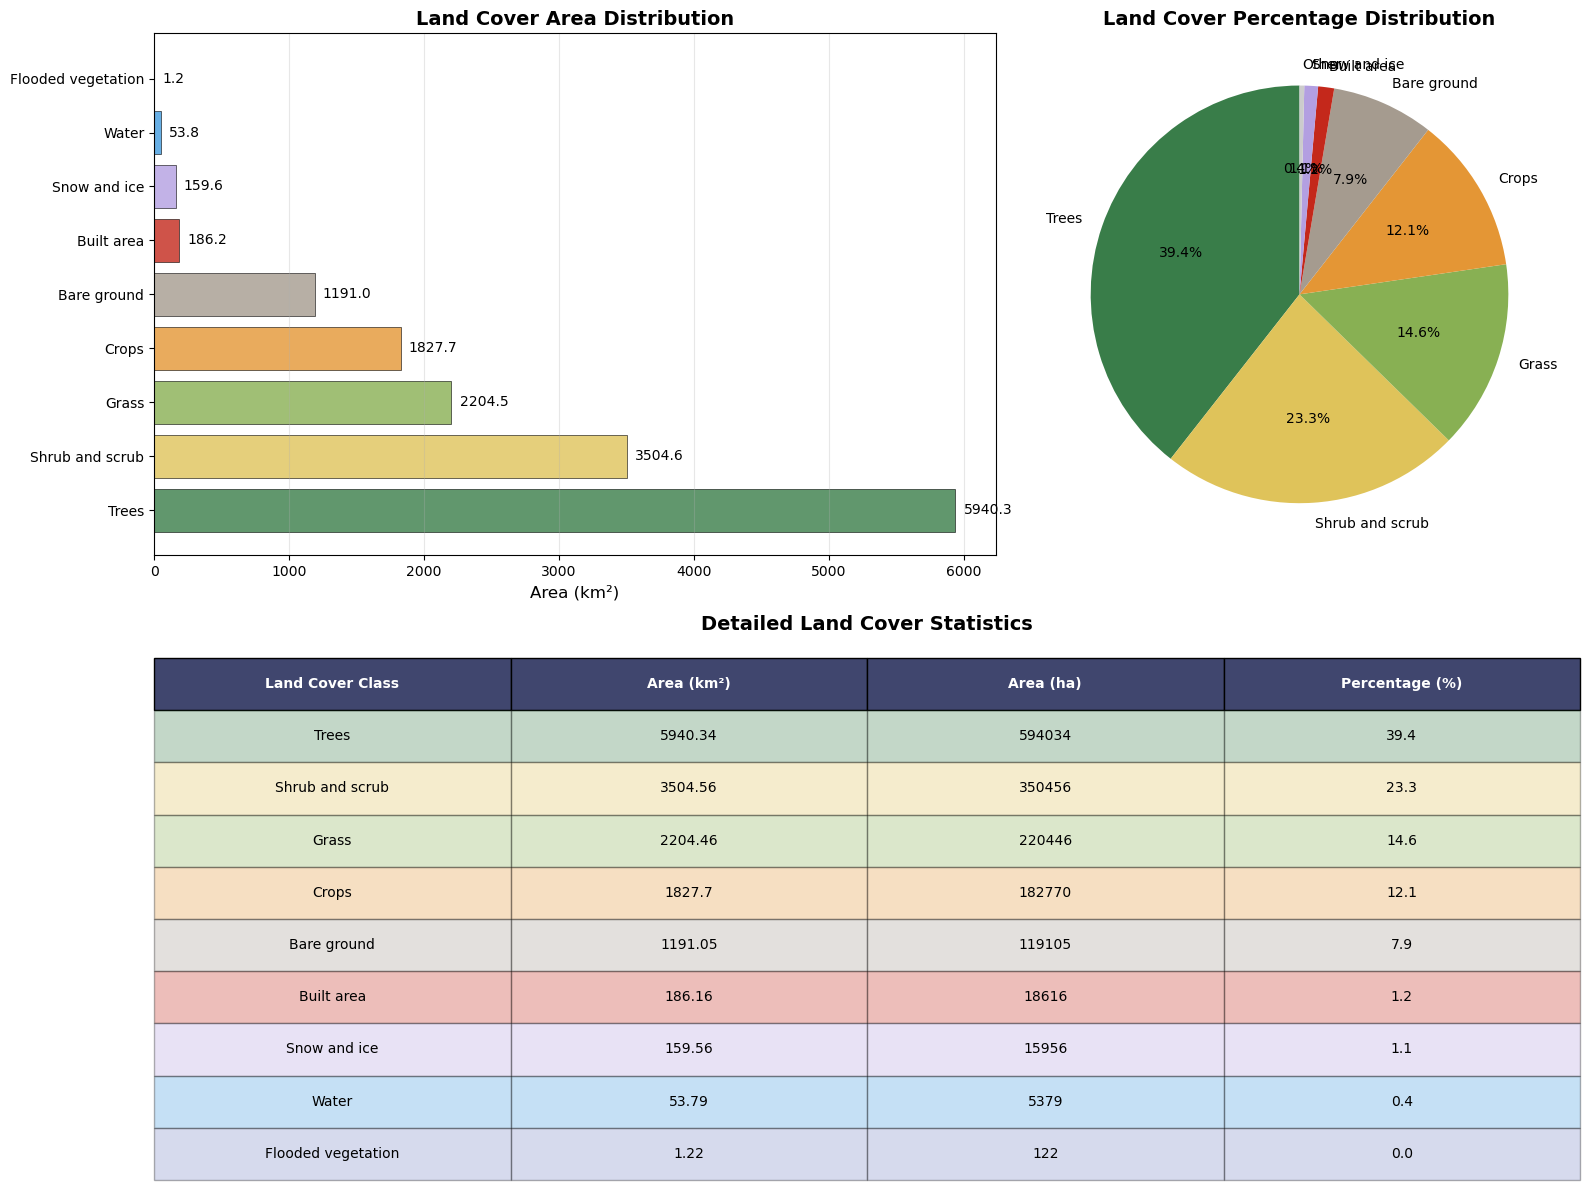

In [6]:
# Create comprehensive visualization of land cover distribution
fig = plt.figure(figsize=(16, 12))

# Create grid layout
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1.5, 1])

# 1. Horizontal bar chart (top left)
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.barh(stats_df['Class_Name'], stats_df['Area_km2'], 
                color=stats_df['Color'], alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Area (km²)', fontsize=12)
ax1.set_title('Land Cover Area Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, area) in enumerate(zip(bars, stats_df['Area_km2'])):
    width = bar.get_width()
    ax1.text(width + max(stats_df['Area_km2']) * 0.01, bar.get_y() + bar.get_height()/2, 
            f'{area:.1f}', ha='left', va='center', fontsize=10)

# 2. Pie chart (top right)
ax2 = fig.add_subplot(gs[0, 1])
# Only show classes with > 1% for better visualization
significant_classes = stats_df[stats_df['Percentage'] >= 1].copy()
other_classes = stats_df[stats_df['Percentage'] < 1]

if len(other_classes) > 0:
    other_row = {
        'Class_Name': 'Other',
        'Percentage': other_classes['Percentage'].sum(),
        'Color': '#CCCCCC'
    }
    significant_classes = pd.concat([significant_classes, pd.DataFrame([other_row])], ignore_index=True)

wedges, texts, autotexts = ax2.pie(significant_classes['Percentage'], 
                                  labels=significant_classes['Class_Name'],
                                  colors=significant_classes['Color'],
                                  autopct='%1.1f%%', startangle=90,
                                  textprops={'fontsize': 10})
ax2.set_title('Land Cover Percentage Distribution', fontsize=14, fontweight='bold')

# 3. Detailed statistics table (bottom)
ax3 = fig.add_subplot(gs[1, :])
ax3.axis('tight')
ax3.axis('off')

# Prepare table data
table_data = stats_df[['Class_Name', 'Area_km2', 'Area_ha', 'Percentage']].copy()
table_data.columns = ['Land Cover Class', 'Area (km²)', 'Area (ha)', 'Percentage (%)']
table_data['Area (km²)'] = table_data['Area (km²)'].round(2)
table_data['Area (ha)'] = table_data['Area (ha)'].round(0).astype(int)
table_data['Percentage (%)'] = table_data['Percentage (%)'].round(1)

# Create table
table = ax3.table(cellText=table_data.values, colLabels=table_data.columns,
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for i in range(len(table_data.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows by land cover class
for i, (_, row) in enumerate(stats_df.iterrows(), 1):
    for j in range(len(table_data.columns)):
        table[(i, j)].set_facecolor(row['Color'])
        table[(i, j)].set_alpha(0.3)

ax3.set_title('Detailed Land Cover Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## Spatial Distribution Analysis

In [ ]:
# Analyze spatial distribution of major land cover types
# Focus on the top 4 most abundant classes
top_classes = stats_df.head(4)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (_, class_info) in enumerate(top_classes.iterrows()):
    ax = axes[i]
    class_id = class_info['Class_ID']
    class_name = class_info['Class_Name']
    class_color = class_info['Color']
    
    # Create binary mask for this class
    class_mask = xr.where(dw_data == class_id, 1, 0)
    
    # Plot the class distribution
    class_mask.plot(ax=ax, cmap=ListedColormap(['white', class_color]), 
                    vmin=0, vmax=1, add_colorbar=False)
    
    ax.set_title(f'{class_name}\n{class_info["Area_km2"]:.1f} km² ({class_info["Percentage"]:.1f}%)',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')

plt.tight_layout()
plt.show()

## Landscape Composition Analysis

In [ ]:
# Group similar land cover types for landscape analysis
landscape_groups = {
    'Forest': [1],  # Trees
    'Grassland': [2],  # Grass
    'Shrubland': [5],  # Shrub and scrub
    'Agricultural': [4],  # Crops
    'Water and Wetlands': [0, 3],  # Water, Flooded vegetation
    'Developed': [6],  # Built area
    'Barren': [7],  # Bare ground
    'Snow/Ice': [8]  # Snow and ice
}

# Calculate grouped statistics
grouped_stats = []
for group_name, class_ids in landscape_groups.items():
    total_area = 0
    total_pixels = 0
    
    for class_id in class_ids:
        if class_id in stats_df['Class_ID'].values:
            class_row = stats_df[stats_df['Class_ID'] == class_id].iloc[0]
            total_area += class_row['Area_km2']
            total_pixels += class_row['Pixels']
    
    if total_area > 0:
        percentage = (total_pixels / total_pixels) * 100 if total_pixels > 0 else 0
        percentage = (total_area / total_area_km2) * 100
        
        grouped_stats.append({
            'Landscape_Type': group_name,
            'Area_km2': total_area,
            'Percentage': percentage
        })

grouped_df = pd.DataFrame(grouped_stats)
grouped_df = grouped_df.sort_values('Area_km2', ascending=False)

# Visualization of landscape composition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Horizontal bar chart
colors_grouped = plt.cm.Set3(np.linspace(0, 1, len(grouped_df)))
bars = ax1.barh(grouped_df['Landscape_Type'], grouped_df['Area_km2'], 
                color=colors_grouped, alpha=0.8, edgecolor='black')

ax1.set_xlabel('Area (km²)', fontsize=12)
ax1.set_title('Landscape Composition by Area', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, area in zip(bars, grouped_df['Area_km2']):
    width = bar.get_width()
    ax1.text(width + max(grouped_df['Area_km2']) * 0.01, 
            bar.get_y() + bar.get_height()/2, 
            f'{area:.1f}', ha='left', va='center', fontsize=10)

# Donut chart
wedges, texts, autotexts = ax2.pie(grouped_df['Area_km2'], 
                                  labels=grouped_df['Landscape_Type'],
                                  colors=colors_grouped,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  pctdistance=0.85)

# Create donut by adding a circle in the center
centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax2.add_artist(centre_circle)
ax2.set_title('Landscape Composition by Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nLandscape Composition Summary:")
print("=" * 40)
for _, row in grouped_df.iterrows():
    print(f"{row['Landscape_Type']:<20}: {row['Area_km2']:>6.1f} km² ({row['Percentage']:>5.1f}%)")

## Edge and Fragmentation Analysis

In [ ]:
# Simple edge analysis for forest patches
from scipy import ndimage

# Focus on forest (trees) for fragmentation analysis
if 1 in stats_df['Class_ID'].values:  # Trees class
    forest_mask = (dw_data.values == 1).astype(int)
    
    # Calculate forest patches
    labeled_forest, num_patches = ndimage.label(forest_mask)
    
    # Calculate patch sizes
    patch_sizes = []
    for i in range(1, num_patches + 1):
        patch_pixels = (labeled_forest == i).sum()
        patch_area_ha = patch_pixels * pixel_area_m2 / 10000
        if patch_area_ha >= 1:  # Only patches >= 1 hectare
            patch_sizes.append(patch_area_ha)
    
    # Statistics
    if patch_sizes:
        patch_sizes = np.array(patch_sizes)
        
        print("Forest Fragmentation Analysis:")
        print(f"Number of forest patches (≥1 ha): {len(patch_sizes)}")
        print(f"Largest patch: {patch_sizes.max():.1f} hectares")
        print(f"Smallest patch: {patch_sizes.min():.1f} hectares")
        print(f"Mean patch size: {patch_sizes.mean():.1f} hectares")
        print(f"Median patch size: {np.median(patch_sizes):.1f} hectares")
        
        # Plot patch size distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram of patch sizes
        ax1.hist(patch_sizes, bins=20, alpha=0.7, color='forestgreen', edgecolor='black')
        ax1.set_xlabel('Patch Size (hectares)')
        ax1.set_ylabel('Number of Patches')
        ax1.set_title('Distribution of Forest Patch Sizes')
        ax1.grid(True, alpha=0.3)
        
        # Log scale histogram for better visualization of range
        ax2.hist(patch_sizes, bins=20, alpha=0.7, color='forestgreen', edgecolor='black')
        ax2.set_xlabel('Patch Size (hectares)')
        ax2.set_ylabel('Number of Patches')
        ax2.set_title('Distribution of Forest Patch Sizes (Log Scale)')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Patch size categories
        small_patches = (patch_sizes < 10).sum()
        medium_patches = ((patch_sizes >= 10) & (patch_sizes < 100)).sum()
        large_patches = (patch_sizes >= 100).sum()
        
        print(f"\nPatch Size Categories:")
        print(f"Small patches (<10 ha): {small_patches} ({small_patches/len(patch_sizes)*100:.1f}%)")
        print(f"Medium patches (10-100 ha): {medium_patches} ({medium_patches/len(patch_sizes)*100:.1f}%)")
        print(f"Large patches (>100 ha): {large_patches} ({large_patches/len(patch_sizes)*100:.1f}%)")
    else:
        print("No forest patches found.")
else:
    print("Trees class not found in the data.")

## Summary and Ecological Insights

In [ ]:
# Generate comprehensive summary
print("=== Dynamic World Land Cover Analysis Summary ===")
print(f"Black Hills Region Land Cover Classification")
print(f"Study Area: {total_area_km2:.1f} km² ({total_area_km2*100:.0f} hectares)")
print("=" * 60)

print("\n🌲 DOMINANT LAND COVER TYPES:")
for i, (_, row) in enumerate(stats_df.head(3).iterrows(), 1):
    print(f"{i}. {row['Class_Name']}: {row['Area_km2']:.1f} km² ({row['Percentage']:.1f}%)")

print("\n🏞️ LANDSCAPE COMPOSITION:")
for _, row in grouped_df.head(5).iterrows():
    print(f"• {row['Landscape_Type']}: {row['Area_km2']:.1f} km² ({row['Percentage']:.1f}%)")

print("\n📊 DIVERSITY METRICS:")
# Calculate Shannon diversity index
proportions = stats_df['Percentage'] / 100
shannon_diversity = -np.sum(proportions * np.log(proportions))
max_diversity = np.log(len(stats_df))
evenness = shannon_diversity / max_diversity

print(f"• Number of land cover classes: {len(stats_df)}")
print(f"• Shannon Diversity Index: {shannon_diversity:.3f}")
print(f"• Evenness: {evenness:.3f}")
print(f"• Dominance (largest class %): {stats_df.iloc[0]['Percentage']:.1f}%")

# Natural vs. Human-influenced areas
natural_classes = [0, 1, 2, 3, 5, 7, 8]  # Water, trees, grass, flooded veg, shrub, bare, snow
human_classes = [4, 6]  # Crops, built area

natural_area = stats_df[stats_df['Class_ID'].isin(natural_classes)]['Area_km2'].sum()
human_area = stats_df[stats_df['Class_ID'].isin(human_classes)]['Area_km2'].sum()

print("\n🌿 NATURAL vs HUMAN INFLUENCE:")
print(f"• Natural landscapes: {natural_area:.1f} km² ({natural_area/total_area_km2*100:.1f}%)")
print(f"• Human-influenced areas: {human_area:.1f} km² ({human_area/total_area_km2*100:.1f}%)")

if 1 in stats_df['Class_ID'].values and 'patch_sizes' in locals():
    print("\n🌳 FOREST CHARACTERISTICS:")
    forest_area = stats_df[stats_df['Class_ID'] == 1]['Area_km2'].iloc[0]
    print(f"• Forest coverage: {forest_area:.1f} km² ({forest_area/total_area_km2*100:.1f}%)")
    print(f"• Number of forest patches: {len(patch_sizes)}")
    print(f"• Average patch size: {patch_sizes.mean():.1f} hectares")
    print(f"• Largest forest patch: {patch_sizes.max():.1f} hectares")

print("\n" + "=" * 60)
print("Analysis based on Google Dynamic World land cover classification")
print("Data represents the most common (mode) land cover class per pixel")